# Adding variables to model: Contract Subjects version

In [12]:
import pandas as pd
import ETL as etl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
SECOPI_PROCESS_API = 'f789-7hwg'
SECOPII_PROCESS_API = 'jbjy-vk9h'
SECOPI_ADDITIONS_API = '7fix-nd37'
SECOPI_PUNISHMENT_API = '4n4q-k399'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [5]:
# General functions
import os

# Get query files function
def get_path(folder, file_path):
    current_directory = os.getcwd()
    return os.path.join(current_directory, '..', folder, file_path)


def get_query(folder, file_path):
    path = get_path(folder, file_path)
    # try to get the query
    with open(path, "r", encoding="utf8") as query_file:
        query = query_file.read()
    
    return query

def parse_to_list(ls):
    ids = [ str(i) for i in ls]
    ids = "'" + "','".join(ids) + "'"
    return ids

## Set Up

In [9]:
procesos_data = pd.read_csv(get_path('data', 'collected_vias_rurales_data.csv'),
                 dtype = {'ID_ADJUDICACION': str},
                 parse_dates=['START_DATE','CONTRACT_DATE'])

procesos_secop_i_data = procesos_data[-procesos_data['GROUP'].str.contains('SECOP II')].copy()

procesos_secop_i_data['HAVE_DEVIATION'] = (procesos_secop_i_data['COST_DEVIATION_NORM']  > 0) | (procesos_secop_i_data['TIME_DEVIATION'] > 0)
procesos_secop_i_data['HAVE_DEVIATION_COST'] = procesos_secop_i_data['COST_DEVIATION_NORM']  > 0
procesos_secop_i_data['HAVE_DEVIATION_TIME'] = procesos_secop_i_data['TIME_DEVIATION']  > 0

#Summary
def summary(x):
    data = {}

    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value norm avg'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation (%)'] = x['COST_DEVIATION_NORM'].mean()*100
    data['time duration avg'] = x['ORIGINAL_DEADLINE'].mean()
    data['time deviation (%)'] = x['TIME_DEVIATION'].mean()*100
    #data['Project intensity norm avg'] = x['PROJECT_INTENSITY_NORM'].mean()

    return pd.Series(data)

# Impression
variables = ['HAVE_DEVIATION_COST','HAVE_DEVIATION_TIME']
procesos_secop_i_data.groupby(variables)[variables].size()
procesos_secop_i_data.groupby(variables).apply(summary)

unique contracts  value norm avg  \
HAVE_DEVIATION_COST HAVE_DEVIATION_TIME                                     
False               False                            97.0     1881.950384   
                    True                             22.0     1784.202816   
True                False                            11.0      792.193718   
                    True                             37.0     2429.958294   

                                         cost deviation (%)  \
HAVE_DEVIATION_COST HAVE_DEVIATION_TIME                       
False               False                          0.000000   
                    True                           0.000000   
True                False                         18.526972   
                    True                          23.790388   

                                         time duration avg  time deviation (%)  
HAVE_DEVIATION_COST HAVE_DEVIATION_TIME                                         
False               False                       107.216495            0.000000  
                    True                        109.727273           74.254723  
True                False                       102.272727            0.000000  
                    True                        119.864865           80.484234

In [ ]:
def class_project(row):
    if row['HAVE_DEVIATION_COST'] and row['HAVE_DEVIATION_TIME']:
        return 'Both deviation'
    elif row['HAVE_DEVIATION_COST'] and not row['HAVE_DEVIATION_TIME']:
        return 'Only cost deviation'
    elif not row['HAVE_DEVIATION_COST'] and row['HAVE_DEVIATION_TIME']:
        return 'Only time deviation'
    else:
        return 'Neither'

# Apply the function to each row
procesos_secop_i_data['DEVIATION_TYPE'] = procesos_secop_i_data.apply(class_project, axis=1)

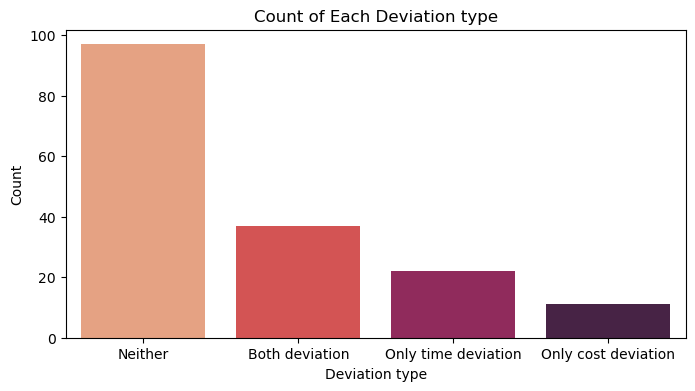

In [34]:
# Create the histogram plot
sorted_counts = procesos_secop_i_data['DEVIATION_TYPE'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.countplot(data=procesos_secop_i_data, 
              x='DEVIATION_TYPE', 
              order=sorted_counts.index,
              palette='rocket_r')
plt.title('Count of Each Deviation type')
plt.xlabel('Deviation type')
plt.ylabel('Count')
plt.show()

c:\Users\nicolas.arrieta\anaconda3\envs\hospital_procurement_data\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


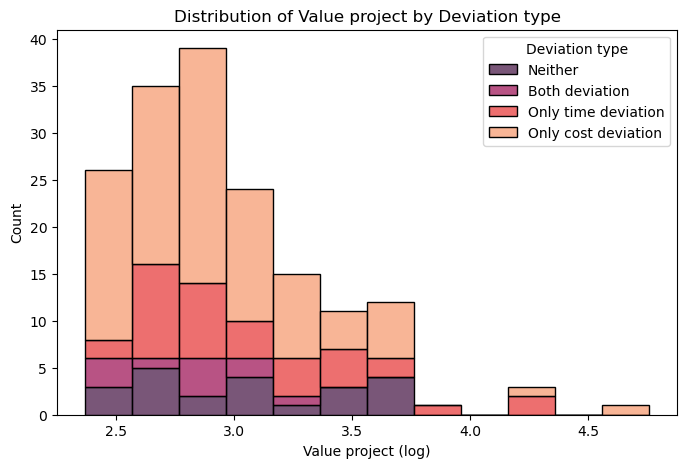

In [51]:
procesos_secop_i_data['CONTRACT_VALUE_LOGNORM'] = np.log10(procesos_secop_i_data['CONTRACT_VALUE_NORM'])

plt.figure(figsize=(8, 5))
sns.histplot(data=procesos_secop_i_data, 
             x='CONTRACT_VALUE_LOGNORM', 
             hue='DEVIATION_TYPE', 
             multiple='stack', palette='rocket_r', bins=12)

plt.title('Distribution of Value project by Deviation type')
plt.xlabel('Value project (log)')
plt.legend(title='Deviation type', labels=procesos_secop_i_data['DEVIATION_TYPE'].value_counts().index)
plt.ylabel('Count')
plt.show()

c:\Users\nicolas.arrieta\anaconda3\envs\hospital_procurement_data\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


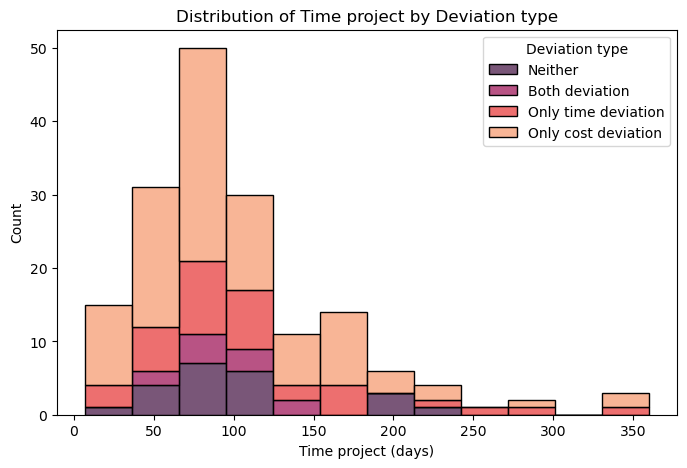

In [53]:
plt.figure(figsize=(8, 5))
sns.histplot(data=procesos_secop_i_data, 
             x='ORIGINAL_DEADLINE', 
             hue='DEVIATION_TYPE', 
             multiple='stack', palette='rocket_r', bins=12)

plt.title('Distribution of Time project by Deviation type')
plt.xlabel('Time project (days)')
plt.legend(title='Deviation type', labels=procesos_secop_i_data['DEVIATION_TYPE'].value_counts().index)
plt.ylabel('Count')
plt.show()

### Municipality Type breakdown

* The 5 & 6 type are the unique categories where the adition projects is under 50%
* The other category has the highest value average project, but seems a missing data because the principal departments are incluided there (Bogotá, Antioquia, etc)

In [41]:
procesos_secop_i_data.groupby(['MUNICIPALITY_TYPE', 'HAVE_DEVIATION']).apply(summary)

unique contracts  value norm avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION                                     
OTHER             False                        9.0     3987.236766   
                  True                         4.0     6180.372166   
TYPE_1            True                         1.0     2708.430242   
TYPE_2            False                        7.0      732.473664   
                  True                         3.0     1536.283323   
TYPE_3            False                        1.0     1436.342120   
                  True                         3.0     1385.343414   
TYPE_4            False                        2.0      788.720881   
                  True                         3.0      650.357908   
TYPE_5            False                        6.0      958.016795   
                  True                         9.0     4500.803783   
TYPE_6            False                       72.0     1844.095223   
                  True                        47.0     1260.041337   

                                  cost deviation (%)  time duration avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION                                          
OTHER             False                     0.000000         150.222222   
                  True                     19.583405         142.500000   
TYPE_1            True                     49.958475          90.000000   
TYPE_2            False                     0.000000          89.000000   
                  True                      8.634974         115.000000   
TYPE_3            False                     0.000000         180.000000   
                  True                     21.839863          95.000000   
TYPE_4            False                     0.000000          70.000000   
                  True                     16.545860          80.000000   
TYPE_5            False                     0.000000          62.500000   
                  True                     35.284131         161.666667   
TYPE_6            False                     0.000000         107.361111   
                  True                     10.577227         106.148936   

                                  time deviation (%)  \
MUNICIPALITY_TYPE HAVE_DEVIATION                       
OTHER             False                     0.000000   
                  True                    146.736111   
TYPE_1            True                    200.000000   
TYPE_2            False                     0.000000   
                  True                      7.142857   
TYPE_3            False                     0.000000   
                  True                     49.074074   
TYPE_4            False                     0.000000   
                  True                     64.444444   
TYPE_5            False                     0.000000   
                  True                     74.334215   
TYPE_6            False                     0.000000   
                  True                     59.437959   

                                  Project intensity norm avg  
MUNICIPALITY_TYPE HAVE_DEVIATION                              
OTHER             False                            40.403593  
                  True                             35.657065  
TYPE_1            True                             30.093669  
TYPE_2            False                             9.311922  
                  True                             16.358158  
TYPE_3            False                             7.979678  
                  True                             12.966082  
TYPE_4            False                            12.032295  
                  True                              7.978296  
TYPE_5            False                            19.030789  
                  True                             21.059501  
TYPE_6            False                            14.342077  
                  True                             11.844322

#### Detail for each adition type

In [42]:
procesos_secop_i_data.groupby(['MUNICIPALITY_TYPE', 'HAVE_DEVIATION_COST']).apply(summary)

unique contracts  value norm avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_COST                                     
OTHER             False                            11.0     3707.613467   
                  True                              2.0     9911.435710   
TYPE_1            True                              1.0     2708.430242   
TYPE_2            False                             9.0      932.494555   
                  True                              1.0     1343.714624   
TYPE_3            False                             1.0     1436.342120   
                  True                              3.0     1385.343414   
TYPE_4            False                             4.0      783.706919   
                  True                              1.0      393.687810   
TYPE_5            False                             7.0     1199.521962   
                  True                              8.0     4732.335135   
TYPE_6            False                            87.0     1835.145132   
                  True                             32.0     1010.599136   

                                       cost deviation (%)  time duration avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_COST                                          
OTHER             False                          0.000000         136.545455   
                  True                          39.166810         210.000000   
TYPE_1            True                          49.958475          90.000000   
TYPE_2            False                          0.000000         102.555556   
                  True                          25.904922          45.000000   
TYPE_3            False                          0.000000         180.000000   
                  True                          21.839863          95.000000   
TYPE_4            False                          0.000000          83.750000   
                  True                          49.637581          45.000000   
TYPE_5            False                          0.000000          68.571429   
                  True                          39.694648         168.750000   
TYPE_6            False                          0.000000         107.977011   
                  True                          15.535302         103.906250   

                                       time deviation (%)  \
MUNICIPALITY_TYPE HAVE_DEVIATION_COST                       
OTHER             False                         40.404040   
                  True                          71.250000   
TYPE_1            True                         200.000000   
TYPE_2            False                          2.380952   
                  True                           0.000000   
TYPE_3            False                          0.000000   
                  True                          49.074074   
TYPE_4            False                         31.666667   
                  True                          66.666667   
TYPE_5            False                          2.040816   
                  True                          81.840278   
TYPE_6            False                         11.802052   
                  True                          55.212674   

                                       Project intensity norm avg  
MUNICIPALITY_TYPE HAVE_DEVIATION_COST                              
OTHER             False                                 38.918700  
                  True                                  39.077450  
TYPE_1            True                                  30.093669  
TYPE_2            False                                  9.377511  
                  True                                  29.860325  
TYPE_3            False                                  7.979678  
                  True                                  12.966082  
TYPE_4            False                                  9.812715  
                  True                                   8.748618  
TYPE_5            False                         

In [43]:
procesos_secop_i_data.groupby(['MUNICIPALITY_TYPE', 'HAVE_DEVIATION_TIME']).apply(summary)

unique contracts  value norm avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_TIME                                     
OTHER             False                             9.0     3987.236766   
                  True                              4.0     6180.372166   
TYPE_1            True                              1.0     2708.430242   
TYPE_2            False                             8.0      808.878784   
                  True                              2.0     1632.567673   
TYPE_3            False                             1.0     1436.342120   
                  True                              3.0     1385.343414   
TYPE_4            False                             2.0      788.720881   
                  True                              3.0      650.357908   
TYPE_5            False                             7.0     1032.358621   
                  True                              8.0     4878.603059   
TYPE_6            False                            81.0     1711.936577   
                  True                             38.0     1403.419372   

                                       cost deviation (%)  time duration avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_TIME                                          
OTHER             False                          0.000000         150.222222   
                  True                          19.583405         142.500000   
TYPE_1            True                          49.958475          90.000000   
TYPE_2            False                          3.238115          83.500000   
                  True                           0.000000         150.000000   
TYPE_3            False                          0.000000         180.000000   
                  True                          21.839863          95.000000   
TYPE_4            False                          0.000000          70.000000   
                  True                          16.545860          80.000000   
TYPE_5            False                          4.289569          75.000000   
                  True                          35.941275         163.125000   
TYPE_6            False                          1.825491         106.913580   
                  True                           9.191181         106.815789   

                                       time deviation (%)  \
MUNICIPALITY_TYPE HAVE_DEVIATION_TIME                       
OTHER             False                          0.000000   
                  True                         146.736111   
TYPE_1            True                         200.000000   
TYPE_2            False                          0.000000   
                  True                          10.714286   
TYPE_3            False                          0.000000   
                  True                          49.074074   
TYPE_4            False                          0.000000   
                  True                          64.444444   
TYPE_5            False                          0.000000   
                  True                          83.625992   
TYPE_6            False                          0.000000   
                  True                          73.515370   

                                       Project intensity norm avg  
MUNICIPALITY_TYPE HAVE_DEVIATION_TIME                              
OTHER             False                                 40.403593  
                  True                                  35.657065  
TYPE_1            True                                  30.093669  
TYPE_2            False                                 11.880472  
                  True                                   9.607075  
TYPE_3            False                                  7.979678  
                  True                                  12.966082  
TYPE_4            False                                 12.032295  
                  True                                   7.978296  
TYPE_5            False                         

In [44]:
# procesos_secop_i_data[procesos_secop_i_data['MUNICIPALITY_TYPE'] == 'OTHER'].groupby(['DEPARTMENT']).size()
procesos_secop_i_data[procesos_secop_i_data['MUNICIPALITY_TYPE'] == 'OTHER']

,CONTRACT_ID,ENTITY_NAME,DEPARTMENT,MUNICIPALITY_TYPE,PROCESS_TYPE,CONTRACT_OBJECT,OBJETC_DETAIL,ESTIMATED_COST_ORIG,CONTRACT_VALUE_ORIG,ADDITIONAL_COST_ORIG,FINAL_COST_ORIG,YEAR,CONTRACT_DATE,START_DATE,ORIGINAL_DEADLINE,END_DATE,ID_ADJUDICACION,URLPROCESO,NIT_ENTIDAD,ID_CONTRATISTA,dpto_y_muni_contratista,MUNICIPALITY,ESTIMATED_COST_NORM,CONTRACT_VALUE_NORM,ADDITIONAL_COST_NORM,FINAL_COST_NORM,ADDITIONAL_TIME,FINAL_DEADLINE,PROJECT_INTENSITY_NORM,PROJECT_INTENSITY_ORIG,AWARD_GROWTH_NORM,AWARD_GROWTH_ORIG,COST_DEVIATION_ORIG,COST_DEVIATION_NORM,TIME_DEVIATION,OWNER,REGION,GROUP,COST_GROUP_QUANTILE,HAVE_DEVIATION,HAVE_DEVIATION_COST,HAVE_DEVIATION_TIME
6,17-1-179303-6641358,TOLIMA - GOBERNACION,TOLIMA,OTHER,LICITACIÓN PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",MEJORAMIENTO Y PAVIMENTACION DE LA VIA SALADO  SAN BERNARDO EN ZONA RURAL DE IBAGUE EN EL DEPARTAMENTO DEL TOLIMA,1.287531e+10,1.284154e+10,5.652561e+09,1.849410e+10,2017.0,2017-11-16,2017-11-16,300.0,2019-07-24,6641358,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=17-1-179303'},800113672,901127921,Tolima,Ibagué,17452.913093,17407.138922,7662.234941,25069.373863,315.0,615.0,58.023796,4.280514e+07,-0.262272,-0.262272,0.440178,0.440178,1.050000,DEPARTMENT_GOVERNMENT,ANDINA,Vias Rurales hasta 2020,Muy Alto,True,True,True
30,16-1-161917-5292598,TOLIMA - GOBERNACION,TOLIMA,OTHER,LICITACIÓN PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",CONSTRUCCION DE OBRAS CIVILES PARA EL MEJORAMIENTO DEL ENTORNO FISICO DE LA VEREDA LA URIBE SECTOR CENTRO POBLADO MUNICIPIO DE RIOBLANCO-TOLIMA (MEJORAMIENTO DE VIAS PAVIMENTACION CON PLACA HUELLAS TIPO INVIAS; SANEAMIENTO BASIC° Y AGUA POTABLES,1.270500e+09,1.246514e+09,0.000000e+00,1.246514e+09,2016.0,2016-11-15,2016-11-15,60.0,2017-04-04,5292598,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=16-1-161917'},800113672,901023632,Tolima,Ibagué,1842.759861,1807.970340,0.000000,1807.970340,80.0,140.0,30.132839,2.077524e+07,-1.887903,-1.887903,0.000000,0.000000,1.333333,DEPARTMENT_GOVERNMENT,ANDINA,Vias Rurales hasta 2020,Muy Alto,True,False,True
33,16-1-164395-5438261,TOLIMA - GOBERNACION,TOLIMA,OTHER,LICITACIÓN PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",MEJORAMIENTO Y PAVIMENTACION DE LA VIA CHUCUNI EN ZONA RURAL DE IBAGUE- DEPARTAMENTO DEL TOLIMA,1.668791e+09,1.665539e+09,5.715438e+08,2.237083e+09,2016.0,2016-12-27,2016-12-27,120.0,2017-06-10,5438261,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=16-1-164395'},800113672,901037527,Bogotá D.C.,Ibagué,2420.450067,2415.732499,828.979049,3244.711548,45.0,165.0,20.131104,1.387949e+07,-0.194905,-0.194905,0.343158,0.343158,0.375000,DEPARTMENT_GOVERNMENT,ANDINA,Vias Rurales hasta 2020,Muy Alto,True,True,True
36,18-21-6643-7981776,CAUCA - ALCALDIA MUNICIPIO DE LA VEGA,CAUCA,OTHER,LICITACIÓN OBRA PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",CONSTRUCCION PLACA HUELLA EN LA VIA ARBELA  LOS PLANES  LA VENTICA  NUEVA ARGELIA EN EL MARCO DEL PROYECTO DE MEJORAMIENTO DE LA RED VIAL TERCIARIA DEL MUNICIPIO DE LA VEGA CAUCA,5.562688e+08,5.562687e+08,0.000000e+00,5.562687e+08,2018.0,2018-12-11,2018-12-20,210.0,2019-07-20,7981776,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=18-21-6643'},891500997,76333572,Cauca,La Vega,712.031318,712.031173,0.000000,712.031173,0.0,210.0,3.390625,2.648898e+06,-0.000020,-0.000020,0.000000,0.000000,0.000000,DEPARTMENT_GOVERNMENT,PACIFICA,Vias Rurales hasta 2020,Medio,False,False,False
50,18-21-1401-7377806,GUAVIARE - GOBERNACION,GUAVIARE,OTHER,LICITACIÓN OBRA PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",CONSTRUCCION OBRAS DE ARTE EN LA VIA EL MORRO - LA FUGA EN LA VEREDA TAGUARA - RESGUARDO INDIGENA FANAJIW DEL MUNICIPIO DE SAN JOSE DEL GUAVIARE - GUAVIARE,2.884738e+09,2.884738e+09,0.000000e+00,2.884738e+09,2018.0,2018-05-29,2018-07-12,360.0,2019-07-12,7377806,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.d

### Region breakdown
* The Andina region shows the most differents in the value of contrats and has the major number of projects
* The orinoquia have the inverse case of the region above

In [45]:
procesos_secop_i_data.groupby(['REGION', 'HAVE_DEVIATION']).apply(summary)

unique contracts  value norm avg  \
REGION    HAVE_DEVIATION                                     
AMAZONIA  False                        4.0     2215.495746   
          True                         1.0     4209.237337   
ANDINA    False                       76.0     1793.061989   
          True                        52.0     2082.491011   
CARIBE    False                        4.0      793.063340   
          True                         3.0      817.052519   
ORINOQUIA False                        6.0     4473.198745   
          True                        11.0     1642.577028   
PACIFICA  False                        7.0     1057.578177   
          True                         3.0     1618.924977   

                          cost deviation (%)  time duration avg  \
REGION    HAVE_DEVIATION                                          
AMAZONIA  False                     0.000000         180.000000   
          True                     18.326741         240.000000   
ANDINA    False                     0.000000         102.605263   
          True                     15.342526         110.653846   
CARIBE    False                     0.000000          82.500000   
          True                     40.484453          50.000000   
ORINOQUIA False                     0.000000         117.500000   
          True                     13.313601         120.000000   
PACIFICA  False                     0.000000         121.000000   
          True                      0.000000         170.000000   

                          time deviation (%)  Project intensity norm avg  
REGION    HAVE_DEVIATION                                                  
AMAZONIA  False                     0.000000                   11.579492  
          True                     87.500000                   17.538489  
ANDINA    False                     0.000000                   14.972315  
          True                     73.515200                   14.727425  
CARIBE    False                     0.000000                   11.147444  
          True                     77.777778                   26.719091  
ORINOQUIA False                     0.000000                   28.055297  
          True                     34.455267                   12.568343  
PACIFICA  False                     0.000000                   30.076979  
          True                     29.629630                    9.691504

#### Detail for each adition type

In [46]:
procesos_secop_i_data.groupby(['REGION', 'HAVE_DEVIATION_COST']).apply(summary)

unique contracts  value norm avg  \
REGION    HAVE_DEVIATION_COST                                     
AMAZONIA  False                             4.0     2215.495746   
          True                              1.0     4209.237337   
ANDINA    False                            92.0     1809.374558   
          True                             36.0     2169.438457   
CARIBE    False                             4.0      793.063340   
          True                              3.0      817.052519   
ORINOQUIA False                             9.0     3449.459039   
          True                              8.0     1732.801053   
PACIFICA  False                            10.0     1225.982217   

                               cost deviation (%)  time duration avg  \
REGION    HAVE_DEVIATION_COST                                          
AMAZONIA  False                          0.000000         180.000000   
          True                          18.326741         240.000000   
ANDINA    False                          0.000000         102.195652   
          True                          22.161426         115.277778   
CARIBE    False                          0.000000          82.500000   
          True                          40.484453          50.000000   
ORINOQUIA False                          0.000000         111.666667   
          True                          18.306202         127.500000   
PACIFICA  False                          0.000000         135.700000   

                               time deviation (%)  Project intensity norm avg  
REGION    HAVE_DEVIATION_COST                                                  
AMAZONIA  False                          0.000000                   11.579492  
          True                          87.500000                   17.538489  
ANDINA    False                         15.258289                   15.376497  
          True                          67.195216                   13.585676  
CARIBE    False                          0.000000                   11.147444  
          True                          77.777778                   26.719091  
ORINOQUIA False                         15.661376                   23.193596  
          True                          29.756944                   12.230149  
PACIFICA  False                          8.888889                   23.961337

In [47]:
procesos_secop_i_data.groupby(['REGION', 'HAVE_DEVIATION_TIME']).apply(summary)

unique contracts  value norm avg  \
REGION    HAVE_DEVIATION_TIME                                     
AMAZONIA  False                             4.0     2215.495746   
          True                              1.0     4209.237337   
ANDINA    False                            85.0     1672.526093   
          True                             43.0     2381.337812   
CARIBE    False                             5.0      903.193597   
          True                              2.0      553.721467   
ORINOQUIA False                             7.0     4045.371721   
          True                             10.0     1658.993773   
PACIFICA  False                             7.0     1057.578177   
          True                              3.0     1618.924977   

                               cost deviation (%)  time duration avg  \
REGION    HAVE_DEVIATION_TIME                                          
AMAZONIA  False                          0.000000         180.000000   
          True                          18.326741         240.000000   
ANDINA    False                          1.739586         102.682353   
          True                          15.115036         112.186047   
CARIBE    False                          5.180984          75.000000   
          True                          47.774218          52.500000   
ORINOQUIA False                          4.289569         122.142857   
          True                          11.642263         117.000000   
PACIFICA  False                          0.000000         121.000000   
          True                           0.000000         170.000000   

                               time deviation (%)  Project intensity norm avg  
REGION    HAVE_DEVIATION_TIME                                                  
AMAZONIA  False                          0.000000                   11.579492  
          True                          87.500000                   17.538489  
ANDINA    False                          0.000000                   14.031205  
          True                          88.902102                   16.536504  
CARIBE    False                          0.000000                   14.890020  
          True                         116.666667                   25.148474  
ORINOQUIA False                          0.000000                   25.455406  
          True                          37.900794                   12.839571  
PACIFICA  False                          0.000000                   30.076979  
          True                          29.629630                    9.691504

### Started Year breakdown

In [48]:
procesos_secop_i_data.groupby(['YEAR', 'HAVE_DEVIATION']).apply(summary)

unique contracts  value norm avg  cost deviation (%)  \
YEAR   HAVE_DEVIATION                                                         
2015.0 False                       26.0     1774.964757            0.000000   
       True                        10.0     1963.285280           12.321938   
2016.0 False                        7.0      916.960896            0.000000   
       True                        11.0     2763.630570           30.786042   
2017.0 False                       14.0      508.725798            0.000000   
       True                         9.0     2890.238625           15.147353   
2018.0 False                       18.0     1295.968065            0.000000   
       True                        13.0     1719.406069           20.711114   
2019.0 False                       16.0     1818.431239            0.000000   
       True                        15.0     1836.436893            8.424204   
2020.0 False                        4.0      869.094777            0.000000   
       True                         4.0     1156.862755            5.530047   
2021.0 False                        8.0     7895.846442            0.000000   
       True                         4.0      667.968941           10.196715   
2022.0 False                        2.0     1400.688547            0.000000   
       True                         4.0     1157.988487            6.833607   
2023.0 False                        2.0      496.181689            0.000000   

                       time duration avg  time deviation (%)  \
YEAR   HAVE_DEVIATION                                          
2015.0 False                   91.346154            0.000000   
       True                   101.000000           71.944444   
2016.0 False                   92.142857            0.000000   
       True                    99.545455           66.111111   
2017.0 False                   81.785714            0.000000   
       True                   105.000000           74.982363   
2018.0 False                  140.000000            0.000000   
       True                   124.615385           68.311966   
2019.0 False                  142.562500            0.000000   
       True                   124.666667           63.935185   
2020.0 False                   73.750000            0.000000   
       True                   144.750000           62.319625   
2021.0 False                   88.125000            0.000000   
       True                    71.250000           81.111111   
2022.0 False                  150.000000            0.000000   
       True                   142.500000           17.301587   
2023.0 False                   67.000000            0.000000   

                       Project intensity norm avg  
YEAR   HAVE_DEVIATION                              
2015.0 False                            17.561061  
       True                             19.821773  
2016.0 False                             9.431262  
       True                             20.729416  
2017.0 False                             7.720490  
       True                             17.537578  
2018.0 False                             8.675287  
       True                             11.154879  
2019.0 False                            11.684091  
       True                             13.011989  
2020.0 False                            14.498084  
       True                              8.926005  
2021.0 False                            67.932501  
       True                             10.368710  
2022.0 False                             8.661399  
       True                              7.349132  
2023.0 False                             7.552648

#### Detail for each adition type

In [49]:
procesos_secop_i_data.groupby(['YEAR', 'HAVE_DEVIATION_COST']).apply(summary)

unique contracts  value norm avg  \
YEAR   HAVE_DEVIATION_COST                                     
2015.0 False                            30.0     1930.597117   
       True                              6.0     1310.670495   
2016.0 False                             9.0      955.681134   
       True                              9.0     3135.281370   
2017.0 False                            16.0      643.528289   
       True                              7.0     3262.550884   
2018.0 False                            20.0     1229.424484   
       True                             11.0     1917.383126   
2019.0 False                            22.0     1923.195834   
       True                              9.0     1592.349430   
2020.0 False                             6.0      990.840660   
       True                              2.0     1079.393084   
2021.0 False                            10.0     6454.503692   
       True                              2.0      646.805194   
2022.0 False                             4.0     1651.227640   
       True                              2.0      414.210240   
2023.0 False                             2.0      496.181689   

                            cost deviation (%)  time duration avg  \
YEAR   HAVE_DEVIATION_COST                                          
2015.0 False                          0.000000          89.833333   
       True                          20.536564         115.000000   
2016.0 False                          0.000000          83.333333   
       True                          37.627384         110.000000   
2017.0 False                          0.000000          81.875000   
       True                          19.475168         111.428571   
2018.0 False                          0.000000         135.000000   
       True                          24.476771         130.909091   
2019.0 False                          0.000000         141.863636   
       True                          14.040341         114.444444   
2020.0 False                          0.000000         100.666667   
       True                          11.060094         135.000000   
2021.0 False                          0.000000          87.000000   
       True                          20.393429          60.000000   
2022.0 False                          0.000000         157.500000   
       True                          13.667214         120.000000   
2023.0 False                          0.000000          67.000000   

                            time deviation (%)  Project intensity norm avg  
YEAR   HAVE_DEVIATION_COST                                                  
2015.0 False                         21.203704                   19.651806  
       True                          13.888889                   10.875192  
2016.0 False                         20.740741                   11.608047  
       True                          60.061728                   21.063333  
2017.0 False                          4.017857                    8.879593  
       True                          87.222222                   17.693083  
2018.0 False                          4.166667                    8.508349  
       True                          73.156566                   11.909236  
2019.0 False                         12.083333                   11.682045  
       True                          77.021605                   13.902255  
2020.0 False                         35.064935                   12.724772  
       True                          19.444444                    8.673860  
2021.0 False                         16.222222                   55.975543  
       True                          81.111111                   12.589711  
2022.0 False                          6.190476                    9.854943  
       True                          22.222222                    3.649775  
2023.0 False                          0.000000                    7.552648

In [50]:
procesos_secop_i_data.groupby(['YEAR', 'HAVE_DEVIATION_TIME']).apply(summary)

unique contracts  value norm avg  \
YEAR   HAVE_DEVIATION_TIME                                     
2015.0 False                            29.0     1679.639619   
       True                              7.0     2438.912503   
2016.0 False                             9.0     1026.761163   
       True                              9.0     3064.201341   
2017.0 False                            16.0      499.401923   
       True                              7.0     3591.982577   
2018.0 False                            22.0     1172.304409   
       True                              9.0     2209.889674   
2019.0 False                            16.0     1818.431239   
       True                             15.0     1836.436893   
2020.0 False                             4.0      869.094777   
       True                              4.0     1156.862755   
2021.0 False                             8.0     7895.846442   
       True                              4.0      667.968941   
2022.0 False                             2.0     1400.688547   
       True                              4.0     1157.988487   
2023.0 False                             2.0      496.181689   

                            cost deviation (%)  time duration avg  \
YEAR   HAVE_DEVIATION_TIME                                          
2015.0 False                          1.874539          94.310345   
       True                           9.836822          92.857143   
2016.0 False                          6.214656          93.333333   
       True                          31.412728         100.000000   
2017.0 False                          0.804229          82.812500   
       True                          17.636929         109.285714   
2018.0 False                          3.665250         132.272727   
       True                          20.956554         136.666667   
2019.0 False                          0.000000         142.562500   
       True                           8.424204         124.666667   
2020.0 False                          0.000000          73.750000   
       True                           5.530047         144.750000   
2021.0 False                          0.000000          88.125000   
       True                          10.196715          71.250000   
2022.0 False                          0.000000         150.000000   
       True                           6.833607         142.500000   
2023.0 False                          0.000000          67.000000   

                            time deviation (%)  Project intensity norm avg  
YEAR   HAVE_DEVIATION_TIME                                                  
2015.0 False                          0.000000                   16.429855  
       True                         102.777778                   25.477075  
2016.0 False                          0.000000                   11.748358  
       True                          80.802469                   20.923021  
2017.0 False                          0.000000                    7.358394  
       True                          96.405896                   21.170109  
2018.0 False                          0.000000                    8.244815  
       True                          98.672840                   13.309182  
2019.0 False                          0.000000                   11.684091  
       True                          63.935185                   13.011989  
2020.0 False                          0.000000                   14.498084  
       True                          62.319625                    8.926005  
2021.0 False                          0.000000                   67.932501  
       True                          81.111111                   10.368710  
2022.0 False                          0.000000                    8.661399  
       True                          17.301587                    7.349132  
2023.0 False                          0.000000                    7.552648

### Punishment last year

In [51]:
ids_entidad = list(set(procesos_secop_i_data['NIT_ENTIDAD']))
ids_contratistas = list(set(procesos_secop_i_data['ID_CONTRATISTA']))

ids_entidad = parse_to_list(ids_entidad)
ids_contratistas = parse_to_list(ids_contratistas)

# Get data
query = get_query('bin/queries', 'request_punishment.sql')
query = query.format(NIT_ENTIDAD_LIST = ids_entidad, NIT_CONTRATISTAS_LIST = ids_contratistas)


temp_punishment_data = etl.extract_data(query, id_data=SECOPI_PUNISHMENT_API, api_key=None)
temp_punishment_data['PENALTY_DATE'] = pd.to_datetime(temp_punishment_data['PENALTY_DATE'])

temp_punishment_data.head()

El numero de contratos extraidos: 529


,PENALTY_ID,NIT_ENTIDAD,ID_CONTRATISTA,PENALTY_VALUE,PENALTY_DATE
0,147-2020,800100532-8,900.659.669-0,1658082,2021-05-06
1,SIN NUMERO,800100134-1,9001209218,74000000,2016-07-13
2,06-334-2015,890204646-3,900260321,999055,2017-12-18
3,06-045-2019,890204646-3,890935513,15903790,2019-06-26
4,ACTA CONJUNTA 088 DE 2015,890204646-3,800183770,1564734671,2020-12-11


In [52]:
# entidad
temp_punishment_entidad_data = pd.merge(procesos_secop_i_data[['CONTRACT_ID','NIT_ENTIDAD','CONTRACT_DATE','END_DATE']], temp_punishment_data, 
                                    how='inner', on='NIT_ENTIDAD')

def penalty_summary(x,pref):
    data = {}

    data['NUM_PENALTIES' + pref] = x['PENALTY_ID'].size
    #data['VAL_PENALTIES'] = x['PENALTY_VALUE'].sum()
    return pd.Series(data)

temp_punishment_entidad_last = temp_punishment_entidad_data[(temp_punishment_entidad_data['CONTRACT_DATE'] > temp_punishment_entidad_data['PENALTY_DATE']) &
                                                            (temp_punishment_entidad_data['PENALTY_DATE'] > (temp_punishment_entidad_data['CONTRACT_DATE'] - pd.DateOffset(years=1)))]\
                                                                .drop_duplicates().groupby('CONTRACT_ID').apply(penalty_summary, '_ENTIDAD_LAST_Y')

procesos_secop_i_data.reset_index(drop = True, inplace = True)
temp_punishment_entidad_last.reset_index(inplace = True)

procesos_secop_i_data = pd.merge(procesos_secop_i_data, 
                                 temp_punishment_entidad_last, 
                                 how='left', on='CONTRACT_ID')

procesos_secop_i_data['NUM_PENALTIES_ENTIDAD_LAST_Y'] = procesos_secop_i_data['NUM_PENALTIES_ENTIDAD_LAST_Y'].fillna(0)

In [53]:
def summary_punishment(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg penalties to entity last year'] = x['NUM_PENALTIES_ENTIDAD_LAST_Y'].mean()
    data['var penalties to entity last year'] = x['NUM_PENALTIES_ENTIDAD_LAST_Y'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_punishment)

,unique contracts,value average,cost deviation,time deviation,avg penalties to entity last year,var penalties to entity last year
HAVE_DEVIATION,,,,,,
False,97.0,1881.950384,0.000000,0.000000,4.969072,17.401780
True,70.0,1969.643567,0.154863,0.658789,5.500000,16.465819


### Time or cost deviation in the past year

In [54]:
# Get data
ids_entidad = list(set(procesos_secop_i_data['NIT_ENTIDAD']))

batch = 2

split_list = len(ids_entidad) // batch

temp_adition_historical = pd.DataFrame()

for i in range(batch):
    starts = (i*split_list)
    ends = (i+1)*split_list

    if i == (batch - 1):
        list_entidades = parse_to_list(ids_entidad[starts:])
    else:
        list_entidades = parse_to_list(ids_entidad[starts:ends])

    query = get_query('bin/queries', 'request_cost_and_time_deviation_historical.sql')
    query = query.format(NIT_ENTIDAD_LIST = list_entidades)

    temp_adition_historical_batch = etl.extract_data(query, id_data=SECOPI_PROCESS_API)

    temp_adition_historical = pd.concat([temp_adition_historical, temp_adition_historical_batch])

temp_adition_historical.head(10)

El numero de contratos extraidos: 8795
El numero de contratos extraidos: 8982


,NIT_ENTIDAD,MONTH_AT,PROJECTS,PROJECTS_W_BOTH_ADITION
0,800012873-7,2008-03-01T00:00:00.000,1,1
1,800012873-7,2008-10-01T00:00:00.000,1,0
2,800012873-7,2008-12-01T00:00:00.000,4,0
3,800012873-7,2009-04-01T00:00:00.000,1,1
4,800012873-7,2009-05-01T00:00:00.000,2,0
5,800012873-7,2009-08-01T00:00:00.000,1,0
6,800012873-7,2011-05-01T00:00:00.000,1,0
7,800012873-7,2011-07-01T00:00:00.000,1,1
8,800012873-7,2011-08-01T00:00:00.000,2,0
9,800012873-7,2011-09-01T00:00:00.000,5,0


In [55]:
temp_adition_historical['MONTH_AT'] = pd.to_datetime(temp_adition_historical['MONTH_AT'])
procesos_secop_i_data['CONTRACT_DATE'] = pd.to_datetime(procesos_secop_i_data['CONTRACT_DATE'])

merged_df = pd.merge(procesos_secop_i_data, temp_adition_historical, how='inner', on='NIT_ENTIDAD',
                     left_index=False, right_index=False, sort=False)

# Filter the merged DataFrame to include only rows where the date falls within the range of stated_at and ended_at columns
merged_df = merged_df[(merged_df['MONTH_AT'] >= (merged_df['CONTRACT_DATE'] - pd.DateOffset(months=12))) & 
                      (merged_df['MONTH_AT'] < merged_df['CONTRACT_DATE'])]

def proportion_cost_adition(x):
    data = {}

    # Convert columns to numeric data types
    x['PROJECTS_W_BOTH_ADITION'] = pd.to_numeric(x['PROJECTS_W_BOTH_ADITION'], errors='coerce')
    x['PROJECTS'] = pd.to_numeric(x['PROJECTS'], errors='coerce')

    # Sum of 'PROJECTS_W_BOTH_ADITION' and 'PROJECTS'
    contracts_w_deviations = x['PROJECTS_W_BOTH_ADITION'].sum()
    total_contracts = x['PROJECTS'].sum()

    # Check for division by zero
    if total_contracts != 0:
        proportion = contracts_w_deviations / total_contracts
    else:
        proportion = None

    # data['deviations'] = contracts_w_deviations
    # data['total'] = total_contracts
    data['PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y'] = proportion

    return pd.Series(data)

merged_df = merged_df.groupby('CONTRACT_ID').apply(proportion_cost_adition)

merged_df = merged_df.reset_index()
merged_df.head()

,CONTRACT_ID,PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y
0,15-1-138089-3735561,0.132278
1,15-1-138416-3768277,0.083900
2,15-1-138758-3764902,0.105691
3,15-1-139262-3824587,0.251309
4,15-1-139495-3883849,0.260870


In [56]:
procesos_secop_i_data = pd.merge(procesos_secop_i_data, 
                                 merged_df, 
                                 how='left', on='CONTRACT_ID')

In [57]:
def summary_deviation(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg deviation to entity last year'] = x['PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y'].mean()
    data['var deviation to entity last year'] = x['PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_deviation)

,unique contracts,value average,cost deviation,time deviation,avg deviation to entity last year,var deviation to entity last year
HAVE_DEVIATION,,,,,,
False,97.0,1881.950384,0.000000,0.000000,0.127377,0.122244
True,70.0,1969.643567,0.154863,0.658789,0.217996,0.129333


## Variables during project

### First addition time

In [58]:
ids = list(set(procesos_secop_i_data['ID_ADJUDICACION']))

ids = parse_to_list(ids)

query = get_query('bin/queries', 'request_first_adding_date.sql').format(LIST_UID = ids)

temp_additions_data = etl.extract_data(query, id_data=SECOPI_ADDITIONS_API, api_key=None)

temp_additions_data.head()

El numero de contratos extraidos: 70


,ID_ADJUDICACION,NUM_ADDITION,NUM_ADDITION_VALUE,NUM_ADDITION_TIME,FIRST_ADDITION_AT,FIRST_ADDITION_TIME_AT,FIRST_ADDITION_VALUE_AT
0,10285913,1,0,1,2021-08-25T00:00:00.000,2021-08-25T00:00:00.000,NaN
1,10296834,2,0,2,2020-12-23T00:00:00.000,2020-12-23T00:00:00.000,NaN
2,10326352,1,1,1,2021-10-15T00:00:00.000,2021-10-15T00:00:00.000,2021-10-15T00:00:00.000
3,10502654,3,1,3,2020-07-17T00:00:00.000,2020-07-17T00:00:00.000,2020-10-09T00:00:00.000
4,10910037,1,1,1,2021-04-16T00:00:00.000,2021-04-16T00:00:00.000,2021-04-16T00:00:00.000


In [59]:
temp_additions_data['FIRST_ADDITION_AT'] = pd.to_datetime(temp_additions_data['FIRST_ADDITION_AT'])
procesos_secop_i_data = pd.merge(procesos_secop_i_data, temp_additions_data, 
                                    how='left', on='ID_ADJUDICACION')

procesos_secop_i_data['DAY_DIFF_FIRST_ADDITION'] = (procesos_secop_i_data['FIRST_ADDITION_AT'] - procesos_secop_i_data['START_DATE']) / np.timedelta64(1, 'D')
procesos_secop_i_data['RATIO_FIRST_ADDITION'] = procesos_secop_i_data['DAY_DIFF_FIRST_ADDITION'] / procesos_secop_i_data['ORIGINAL_DEADLINE']

bins = [0, 0.25, 0.5, 0.75, 1, float('inf')]  # Define your bin edges
labels = ['very early', 'early', 'medium', 'late', 'very late']  # Assign labels to bins

# Create a new categorical column based on the bins
procesos_secop_i_data['FIRST_ADITION_TIME_GROUP'] = pd.cut(procesos_secop_i_data['RATIO_FIRST_ADDITION'], bins=bins, labels=labels, right=False)

procesos_secop_i_data['FIRST_ADITION_TIME_GROUP'] = procesos_secop_i_data['FIRST_ADITION_TIME_GROUP'].cat.add_categories('NA').fillna('NA')

procesos_secop_i_data[['URLPROCESO','START_DATE', 'ORIGINAL_DEADLINE', 'FIRST_ADDITION_AT', 'DAY_DIFF_FIRST_ADDITION', 'FIRST_ADITION_TIME_GROUP']].head(5)

,URLPROCESO,START_DATE,ORIGINAL_DEADLINE,FIRST_ADDITION_AT,DAY_DIFF_FIRST_ADDITION,FIRST_ADITION_TIME_GROUP
0,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=17-1-182595'},2017-12-27,90.0,NaT,NaN,NA
1,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=15-1-138089'},2015-07-06,120.0,2015-10-27,113.0,late
2,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=15-1-141972'},2015-08-07,120.0,2015-11-24,109.0,late
3,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=15-1-143842'},2015-09-17,90.0,NaT,NaN,NA
4,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=19-1-202937'},2019-09-16,90.0,2019-09-06,-10.0,NA


In [60]:
procesos_secop_i_data[procesos_secop_i_data['HAVE_DEVIATION']].groupby(['FIRST_ADITION_TIME_GROUP']).apply(summary)

C:\Users\nicolas.arrieta\AppData\Local\Temp\ipykernel_16536\3803707511.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  procesos_secop_i_data[procesos_secop_i_data['HAVE_DEVIATION']].groupby(['FIRST_ADITION_TIME_GROUP']).apply(summary)


,unique contracts,value norm avg,cost deviation (%),time duration avg,time deviation (%),Project intensity norm avg
FIRST_ADITION_TIME_GROUP,,,,,,
very early,2.0,453.679272,22.327991,120.000000,37.777778,3.851164
early,2.0,493.250134,13.700542,120.000000,6.666667,4.527996
medium,2.0,1049.806568,47.716720,135.000000,25.000000,7.008888
late,13.0,1494.166619,6.594305,98.769231,95.994561,15.896891
very late,50.0,2263.250557,16.216491,117.000000,63.160714,15.580498
NA,1.0,1294.883879,20.000000,90.000000,66.666667,14.387599


In [61]:
#procesos_secop_i_data['NUM_ADDITION'] = procesos_secop_i_data['NUM_ADDITION'].astype(int)
procesos_secop_i_data.groupby('NUM_ADDITION').apply(summary).sort_values(by='NUM_ADDITION', ascending=True)

,unique contracts,value norm avg,cost deviation (%),time duration avg,time deviation (%),Project intensity norm avg
NUM_ADDITION,,,,,,
1,44.0,1126.577650,14.883256,103.068182,35.520382,11.077178
2,11.0,3777.298722,17.400038,161.272727,83.208219,17.684825
3,9.0,1834.653255,7.749638,88.333333,112.716049,19.642013
4,3.0,2075.909810,23.680671,110.000000,174.814815,22.430624
5,2.0,9158.565884,46.656664,180.000000,250.000000,36.595172
6,1.0,5698.606692,3.675276,180.000000,94.444444,31.658926


### Punishment during the project

In [62]:
# entidad
temp_punishment_entidad_active = temp_punishment_entidad_data[(temp_punishment_entidad_data['END_DATE'] > temp_punishment_entidad_data['PENALTY_DATE']) &
                                                            (temp_punishment_entidad_data['PENALTY_DATE'] > temp_punishment_entidad_data['CONTRACT_DATE'])]\
                                                                .drop_duplicates().groupby('CONTRACT_ID').apply(penalty_summary, '_ENTIDAD_ACTIVE')

#union new rows
procesos_secop_i_data.reset_index(drop = True, inplace = True)
temp_punishment_entidad_active.reset_index(inplace = True)

procesos_secop_i_data = pd.merge(procesos_secop_i_data, 
                                 temp_punishment_entidad_active, 
                                 how='left', on='CONTRACT_ID')

def summary_punishment_v2(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg penalties to entity during project'] = x['NUM_PENALTIES_ENTIDAD_ACTIVE'].mean()
    data['var penalties to entity during project'] = x['NUM_PENALTIES_ENTIDAD_ACTIVE'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_punishment_v2)

,unique contracts,value average,cost deviation,time deviation,avg penalties to entity during project,var penalties to entity during project
HAVE_DEVIATION,,,,,,
False,97.0,1881.950384,0.000000,0.000000,20.000000,13.820275
True,70.0,1969.643567,0.154863,0.658789,18.333333,10.559356


In [63]:
procesos_secop_i_data.to_csv(get_path('data', 'collected_obra_data_v3.csv'), index=False)